# Embedding 与LSTM实战IMDB文本分类

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


## 数据读取

In [3]:
imdb = keras.datasets.imdb
# 词表大小
vocab_size = 10000
# 从索引多少时构建
index_from = 3
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words = vocab_size, index_from = index_from)

字符级的model：char-level model即26个字母和9个数字

subword-level model

eg: "hello" -> "he" "ll" "o"

In [4]:
# 载入词表
word_index = imdb.get_word_index()
print(len(word_index))
# print(word_index)

88584


In [5]:
# 索引从3开始，所以词表全部偏移3
word_index = {k : (v + 3) for k, v in word_index.items()}

In [6]:
# 添加必要的特殊字符
word_index['<PAD>'] = 0 # padding填充
word_index['<START>'] = 1 # 开始
word_index['<UNK>'] = 2 # 找不到时填补
word_index['<EOS>'] = 3 # 结束

# 构建倒排索引：id到词的索引
reverse_word_index = dict([(value, key) for key, value in word_index.items()])

In [7]:
# 查看train_data具体文本
def decode_review(text_ids):
    return ' '.join(
        [reverse_word_index.get(word_id, '<UNK>') for word_id in text_ids])

decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [8]:
# padding
max_length = 500

train_data = keras.preprocessing.sequence.pad_sequences(
    train_data, value = word_index['<PAD>'], padding = 'post', maxlen = max_length)

test_data = keras.preprocessing.sequence.pad_sequences(
    test_data, value = word_index['<PAD>'], padding = 'post', maxlen = max_length)

print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

## 模型构建

In [9]:
embedding_dim = 16 # 每个词Embedding成长度为16的向量
batch_size = 128

single_lstm_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.LSTM(units=64, return_sequences=False),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid'),
])
single_lstm_model.summary()
single_lstm_model.compile(
    optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 16)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 184,961
Trainable params: 184,961
Non-trainable params: 0
_________________________________________________________________


In [10]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3),
]

# 训练
history_single_lstm = single_lstm_model.fit(
    train_data, train_labels, epochs = 30, batch_size = batch_size,
    validation_split = 0.2, callbacks = callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 15s 750us/sample - loss: 0.6934 - accuracy: 0.5038 - val_loss: 0.6927 - val_accuracy: 0.5180
Epoch 2/30
20000/20000 [==============================] - 11s 557us/sample - loss: 0.6883 - accuracy: 0.5154 - val_loss: 0.6875 - val_accuracy: 0.5226
Epoch 3/30
20000/20000 [==============================] - 11s 559us/sample - loss: 0.6781 - accuracy: 0.5317 - val_loss: 0.6901 - val_accuracy: 0.5156
Epoch 4/30
20000/20000 [==============================] - 11s 559us/sample - loss: 0.6566 - accuracy: 0.5339 - val_loss: 0.6958 - val_accuracy: 0.5188
Epoch 5/30
20000/20000 [==============================] - 11s 561us/sample - loss: 0.7566 - accuracy: 0.5379 - val_loss: 0.6934 - val_accuracy: 0.5144


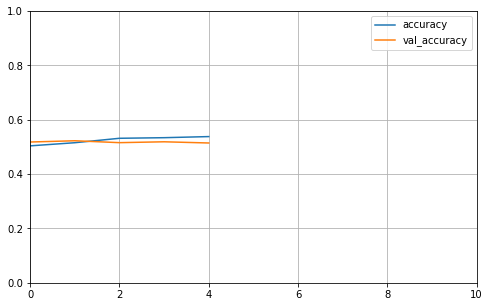

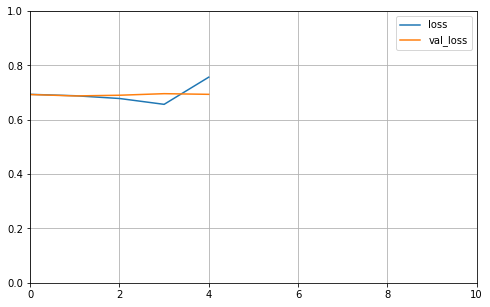

In [11]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history_single_lstm, 'accuracy', 10, 0, 1)
plot_learning_curves(history_single_lstm, 'loss', 10, 0, 1)

In [ ]:
single_lstm_model.evaluate(test_data, test_labels, batch_size = batch_size)

## 模型改进：多层双向LSTM

In [13]:
embedding_dim = 16 # 每个词Embedding成长度为16的向量
batch_size = 128

lstm_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(units=64, return_sequences=False)),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid'),
])
lstm_model.summary()
lstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 128)          41472     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 308,609
Trainable params: 308,609
Non-trainable params: 0
_________________________________________________________________


In [14]:
callbacks = [keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3)]

# 训练
history_lstm = lstm_model.fit(
    train_data, train_labels, epochs = 30, batch_size = batch_size,
    validation_split = 0.2, callbacks = callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 53s 3ms/sample - loss: 0.5952 - accuracy: 0.6576 - val_loss: 0.4380 - val_accuracy: 0.8066
Epoch 2/30
20000/20000 [==============================] - 46s 2ms/sample - loss: 0.3701 - accuracy: 0.8479 - val_loss: 0.4258 - val_accuracy: 0.8228
Epoch 3/30
20000/20000 [==============================] - 46s 2ms/sample - loss: 0.4125 - accuracy: 0.8200 - val_loss: 0.5934 - val_accuracy: 0.7184
Epoch 4/30
20000/20000 [==============================] - 46s 2ms/sample - loss: 0.3705 - accuracy: 0.8443 - val_loss: 0.4216 - val_accuracy: 0.8188
Epoch 5/30
20000/20000 [==============================] - 46s 2ms/sample - loss: 0.3045 - accuracy: 0.8804 - val_loss: 0.4450 - val_accuracy: 0.8102
Epoch 6/30
20000/20000 [==============================] - 46s 2ms/sample - loss: 0.3331 - accuracy: 0.8717 - val_loss: 0.4467 - val_accuracy: 0.8076
Epoch 7/30
20000/20000 [==============================] -

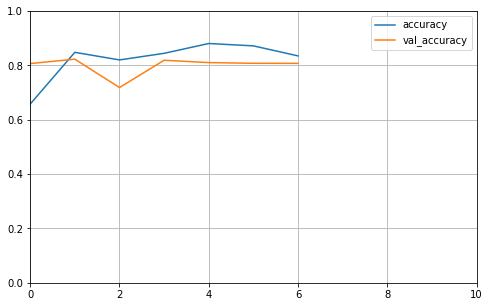

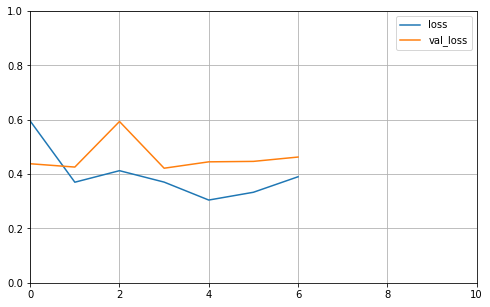

In [15]:
plot_learning_curves(history_lstm, 'accuracy', 10, 0, 1)
plot_learning_curves(history_lstm, 'loss', 10, 0, 1)

In [ ]:
lstm_model.evaluate(test_data, test_labels, batch_size = batch_size)

## 模型改进：单层双向LSTM

In [17]:
embedding_dim = 16 # 每个词Embedding成长度为16的向量
batch_size = 128

bi_lstm_model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(units=32, return_sequences=False)),
    keras.layers.Dense(32, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid'),
])
bi_lstm_model.summary()
bi_lstm_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 174,657
Trainable params: 174,657
Non-trainable params: 0
_________________________________________________________________


In [18]:
callbacks = [keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3)]

# 训练
history_bi_lstm = bi_lstm_model.fit(
    train_data, train_labels, epochs = 30, batch_size = batch_size,
    validation_split = 0.2, callbacks = callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 17s 872us/sample - loss: 0.5780 - accuracy: 0.6787 - val_loss: 0.3567 - val_accuracy: 0.8490
Epoch 2/30
20000/20000 [==============================] - 14s 677us/sample - loss: 0.2703 - accuracy: 0.8938 - val_loss: 0.3072 - val_accuracy: 0.8784
Epoch 3/30
20000/20000 [==============================] - 14s 676us/sample - loss: 0.1877 - accuracy: 0.9317 - val_loss: 0.3496 - val_accuracy: 0.8788
Epoch 4/30
20000/20000 [==============================] - 14s 677us/sample - loss: 0.1539 - accuracy: 0.9462 - val_loss: 0.3346 - val_accuracy: 0.8800
Epoch 5/30
20000/20000 [==============================] - 13s 673us/sample - loss: 0.1175 - accuracy: 0.9615 - val_loss: 0.3753 - val_accuracy: 0.8714


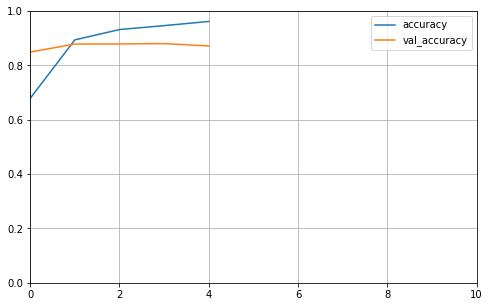

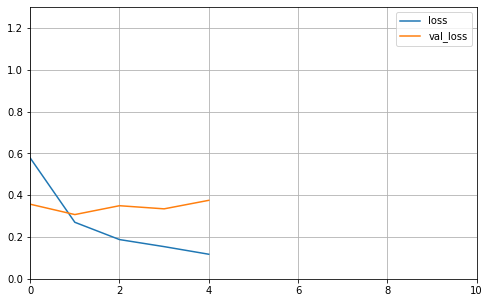

In [19]:
plot_learning_curves(history_bi_lstm, 'accuracy', 10, 0, 1)
plot_learning_curves(history_bi_lstm, 'loss', 10, 0, 1.3)

In [ ]:
bi_lstm_model.evaluate(test_data, test_labels, batch_size = batch_size)